# Harmonic and damped oscillator - interpolation and fit

This notebook is used for analysis of the oscillation data from the first Tier 1 Lab of Phys 5BL.

For more details on the theory behind the various oscillator models, see the lab manual. 

The case of the constant-friction oscillator is handled differently than the other two, and is done at the end of the notebook.

## Data loading and interpolation

We choose to do interpolation so that the various fits and peak picking converge more quickly.


In [2]:
import numpy as np
import scipy.optimize as opt
from scipy.interpolate import interp1d
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

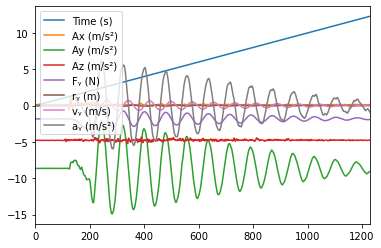

In [3]:
df = pd.read_csv('data/lab7 part 3.csv')
df.plot()

In [4]:
# check the data and headers
file = open('data\lab7 part 3.csv', 'r')
print(file.read())

Time (s),Ax (m/sÂ²),Ay (m/sÂ²),Az (m/sÂ²),Fáµ§ (N),ráµ§ (m),váµ§ (m/s),aáµ§ (m/sÂ²)
0.009999999776482582,0.14179480075836182,-8.643324851989746,-4.782891750335693,-1.8188018798828125,0,0,0
0.019999999552965164,0.13750602304935455,-8.641661643981934,-4.786596298217773,-1.8210794925689697,0,0,0
0.029999999329447746,0.1365021914243698,-8.638326644897461,-4.782186031341553,-1.821798324584961,0,0,0
0.03999999910593033,0.1345306634902954,-8.6328706741333,-4.781027793884277,-1.824607491493225,0,0,0
0.05000000074505806,0.1335475593805313,-8.627821922302246,-4.781197547912598,-1.8283531665802002,0,0,0
0.05999999865889549,0.1347004622220993,-8.622873306274414,-4.7824296951293945,-1.8292895555496216,0,0,0
0.07000000029802322,0.13682526350021362,-8.61976432800293,-4.784221172332764,-1.8283531665802002,0,0,0
0.07999999821186066,0.13827772438526154,-8.626331329345703,-4.789487361907959,-1.8264802694320679,0,0,0
0.09000000357627869,0.14086104929447174,-8.632609367370605,-4.784361362457275,-1.82460749

In [5]:
# Input the data into arrays. You might also want to look at the wheel output, to better choose the quietest sensor
tx, aydata, Fdata= np.loadtxt("data\lab7 part 3.csv", delimiter=",", skiprows=1, usecols=(0,2,4), unpack=True)

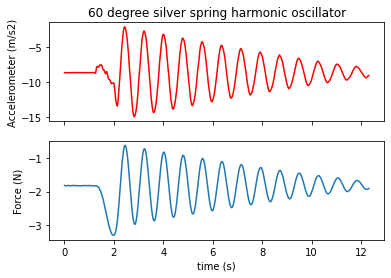

In [6]:
# Two subplots, the x-axis array is shared
# Choose the sensor for fitting based on quietest data
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(tx, aydata,'r', label="accelerometer")
axarr[0].set_title('60 degree silver spring harmonic oscillator')
axarr[0].set_ylabel('Accelerometer (m/s2)')
axarr[1].plot(tx, Fdata)
axarr[1].set_xlabel('time (s)')
axarr[1].set_ylabel('Force (N)')
plt.show()

## Interpolation

The online repository CSV files have already are have been interpolated. We're adding linear interpolation because the constant friction case behaves better with interpolation. We use the Python command:

`interp1d(tx, aydata)`



In [7]:
# Creates an interpolating function 
yinterp = interp1d(tx, aydata, kind="linear")

### Select region in data for fitting and interpolation

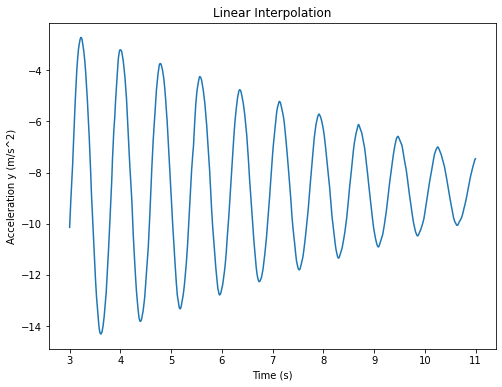

In [8]:
# Set the start time and stop time to select a good region of your data. Don't use the first peak to allow for IOLab sensor settling.
# Use the interpolating function to estimate values at the desired time points

plt.figure(figsize=(8,6))
plt.title("Linear Interpolation")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration y (m/s^2)")

start_time = 3
stop_time = 11
step_size = 0.005
tvals = np.arange(start_time, stop_time, step_size)  
yvals = yinterp(tvals)

plt.plot(tvals, yvals)

plt.show()

## Nonlinear fits

For the cases of simple harmonic motion, and motion with velocity-dependent friction, we fit to the full time series of data. We've defined 4 models below:

Simple harmonic motion for acceleration: $a_{harmonic} = B-A\omega^2\cos(\omega t+\phi),$

Simple harmonic motion for position: $y_{harmonic} = B+A\cos(\omega t+\phi),$

Velocity-dependent friction damping for acceleration: $a_{damped}=B+A\exp^{-\beta t}[(\beta^2-\omega^2)\cos(\omega t+\phi)+2\beta\omega\sin(\omega t + \phi],$

Velocity-dependent friction damping for position: $y_{damped}=B+A\exp^{-\beta t}\cos(\omega t+\phi),$

where t is time, A is the amplitude, B is the offset, $\omega=2\pi f$ is the angular frequency, $\phi$ is the phase, $\beta$ is the damping

### Define the model:

In [9]:
# Defines the various oscillator models that we fit to:

# Simple harmonic motion using acceleration
def simple_a(t, A, B, w, phi):                  # inputs: t:time, A:amplitude, B:offset, w:angular frequency, phi:phase
    return B - A * (w**2) * np.cos(w*t + phi)   # output: acceleration

# Simple harmonic motion using position
def simple_y(t, A, B, w, phi):       # inputs: t:time, A:amplitude, B:offset, w:angular frequency, phi:phase
    return B + A*np.cos(w*t + phi)   # output: position

# Velocity-dependent friction using acceleration
def vdamped_a(t, A, B, w, phi, beta):    # inputs: t:time, A:amplitude, B:offset, w:ang. frequency, phi:phase, beta:damping
    return B + A * np.exp(-beta*t) * ((beta**2-w**2)*np.cos(w*t + phi)+2*beta*w*np.sin(w*t+phi))   # output: acceleration

# Velocity-dependent friction using position
def vdamped_y(t, A, B, w, phi, beta):    # inputs: t:time, A:amplitude, B:offset, w:ang. frequency, phi:phase, beta:damping
    return B + A * np.exp(-beta*t) * np.cos(w*t + phi)        # output: position



### Choose the model and initial fit parameter values then graph:


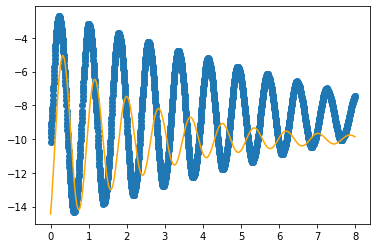

In [10]:
# Fits to the (nonlinear) harmonic function

# Choose the model you wish to fit to: simple_y, simple_a, vdamped_y, vdamped_a
# In this example, we chose simple_a  
oscillator_model=vdamped_a


# Initial guess values of fit parameters determined here:
    # If using simple_a or simple_y, fit parameters are:  [A, B, w, phi]
    # If using vdamped_a or vdamped_y, fit parameters are: [ A, B, w, phi, beta]

Ainit, Binit, winit, phiinit, betainit=[0.1, -10, 7.5, 0.56, 0.4]

# Graph
# plt.plot(tvals-start_time, oscillator_model(tvals-start_time, Ainit, Binit, winit, phiinit), color='orange')
plt.plot(tvals-start_time, oscillator_model(tvals-start_time, Ainit, Binit, winit, phiinit, betainit), color='orange')
plt.scatter(tvals-start_time, yvals)
plt.show()

# If using damped harmonic oscillator, code becomes:
    # plt.plot(tvals-start_time, oscillator_model(tvals-start_time, Ainit, Binit, winit, phiinit, betainit), color='orange')

## Perform the fit then plot

In [11]:
# Perform the fit
# start_pars=[Ainit, Binit, winit, phiinit]
start_pars=[Ainit, Binit, winit, phiinit, betainit]
    #If using damped harmonic oscillator code becomes: start_pars=[Ainit, Binit, winit, phiinit, betainit]

# pars, cov = opt.curve_fit(oscillator_model, tvals-start_time, yvals, p0=start_pars)
pars, cov = opt.curve_fit(oscillator_model, tvals-start_time, yvals, p0=start_pars)
    #If using damped harmonic oscillator code becomes: pars, cov = opt.curve_fit(oscillator_model, tvals-start_time, yvals, p0=start_pars)

# [A, B, w, phi] = pars
[A, B, w, phi, beta] = pars
    # If using damped harmonic oscillator code becomes: [A, B, w, phi, beta] = pars

# Error in fitting parameters
std_errs = np.sqrt(np.diag(cov))

print(np.transpose([pars, std_errs]))

[[ 1.00952664e-01  2.28330870e-04]
 [-8.64071186e+00  3.79957631e-03]
 [ 8.03655986e+00  7.12792355e-04]
 [ 1.22202944e+00  2.18435675e-03]
 [ 1.72010361e-01  7.36838588e-04]]


### Values predicted from fit

In [12]:
# Choose simple harmonic oscillator model simple_a for this example:
# ypred = oscillator_model(tvals-start_time, A, B, w, phi)
ypred = oscillator_model(tvals-start_time, A, B, w, phi, beta)

# For damped harmonic fit, use vdamped_a or vdamped_y for oscillator model: 
    #ypred = oscillator_model(tvals-start_time, A, B, w, phi, beta) 

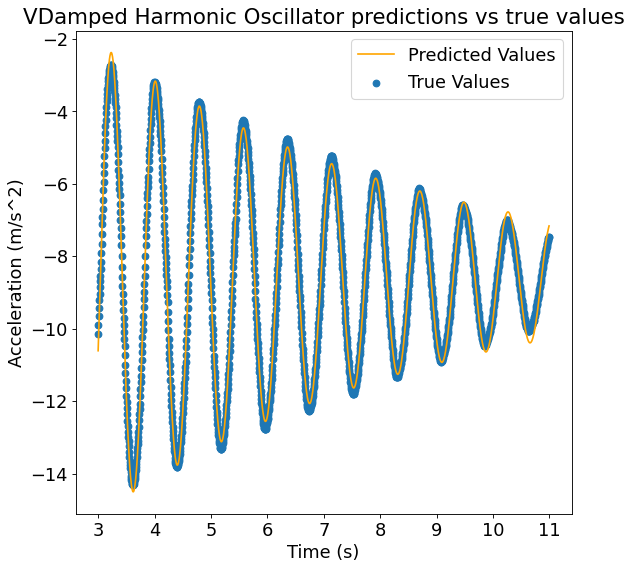

In [13]:
# Best-fit plots

# Sets figure size etc.
fig1=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': '16'})

# Data and fit
plt.scatter(tvals, yvals, label="True Values")
plt.plot(tvals, ypred, color='orange', label="Predicted Values")


# Axes label and title
plt.legend()
plt.title("VDamped Harmonic Oscillator predictions vs true values")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s^2)")
plt.show()

## Constant friction case 

Instead of fitting the full trajectory, we instead compare the amplitudes of successive extrema (turning points). The general equation is:
$$A_n-A_{n+1}=\frac{2f}{k}$$
where $f$ is the coefficient of static friction and $A_n$ is the amplitude for the nth peak. Successive turning points are a maximum followed by a minimum (or vice versa).

There are scipy functions that find these extrema well, but it is also not too hard to do it manually.

In [14]:
from scipy.signal import argrelextrema as get_extrema_indices

In [15]:
# How many neighboring points to compare to for min/max criteria
neighborhood_size = 5

max_indices = get_extrema_indices(yvals, np.greater, order=neighborhood_size)
min_indices = get_extrema_indices(yvals, np.less, order=neighborhood_size)

print("Maxima found: ", np.size(max_indices))
print("Minima found: ", np.size(min_indices))

Maxima found:  10
Minima found:  10


In [16]:
y_max = yvals[max_indices]
t_max = tvals[max_indices]

y_min = yvals[min_indices]
t_min = tvals[min_indices]

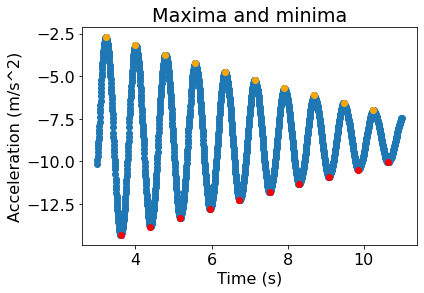

In [45]:
# Make a plot to check the  located max, min are in the right place 
# Be sure to check that the number of maxima, minima that appear on the plot are the same as what's printed above

plt.scatter(tvals, yvals)
plt.scatter(t_max, y_max, color='orange')
plt.scatter(t_min, y_min, color='red')
plt.title("Maxima and minima")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s^2)")
plt.show()

Giving these maxima and minima, it's now up to you to define an appropriate function for evaluating the model given above (and from the lab manual).

In [65]:
# Define your function here
def fit_maxima(t, m, b):
    return t*m + b

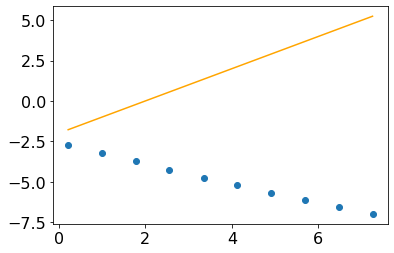

In [66]:
# Fits to the (nonlinear) harmonic function

# Choose the model you wish to fit to: simple_y, simple_a, vdamped_y, vdamped_a
# In this example, we chose simple_a  
oscillator_model=fit_maxima


# Initial guess values of fit parameters determined here:
    # If using simple_a or simple_y, fit parameters are:  [A, B, w, phi]
    # If using vdamped_a or vdamped_y, fit parameters are: [ A, B, w, phi, beta]

minit, binit = [1, -2]

# Graph
# plt.plot(tvals-start_time, oscillator_model(tvals-start_time, Ainit, Binit, winit, phiinit), color='orange')
plt.plot(t_max-start_time, oscillator_model(t_max-start_time, minit, binit), color='orange')
plt.scatter(t_max-start_time, y_max)
plt.show()

# If using damped harmonic oscillator, code becomes:
    # plt.plot(tvals-start_time, oscillator_model(tvals-start_time, Ainit, Binit, winit, phiinit, betainit), color='orange')

In [67]:
# Perform the fit
# start_pars=[Ainit, Binit, winit, phiinit]
start_pars=[minit, binit]
    #If using damped harmonic oscillator code becomes: start_pars=[Ainit, Binit, winit, phiinit, betainit]

# pars, cov = opt.curve_fit(oscillator_model, tvals-start_time, yvals, p0=start_pars)
pars, cov = opt.curve_fit(oscillator_model, t_max-start_time, y_max, p0=start_pars)
    #If using damped harmonic oscillator code becomes: pars, cov = opt.curve_fit(oscillator_model, tvals-start_time, yvals, p0=start_pars)

# [A, B, w, phi] = pars
[m, b] = pars
    # If using damped harmonic oscillator code becomes: [A, B, w, phi, beta] = pars

# Error in fitting parameters
std_errs = np.sqrt(np.diag(cov))

print(np.transpose([pars, std_errs]))

[[-0.61284006  0.00803272]
 [-2.63782976  0.03501317]]


In [68]:
# Choose simple harmonic oscillator model simple_a for this example:
# ypred = oscillator_model(tvals-start_time, A, B, w, phi)
ypred = oscillator_model(t_max-start_time, m, b)

# For damped harmonic fit, use vdamped_a or vdamped_y for oscillator model: 
    #ypred = oscillator_model(tvals-start_time, A, B, w, phi, beta) 

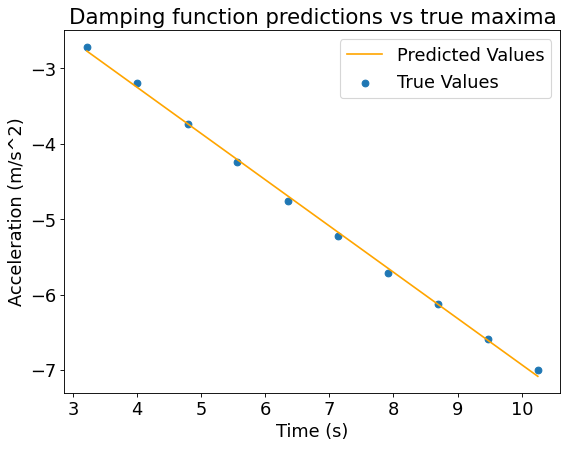

In [69]:
# Best-fit plots

# Sets figure size etc.
fig1=plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': '16'})

# Data and fit
plt.scatter(t_max, y_max, label="True Values")
plt.plot(t_max, ypred, color='orange', label="Predicted Values")


# Axes label and title
plt.legend()
plt.title("Damping function predictions vs true maxima")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s^2)")
plt.show()

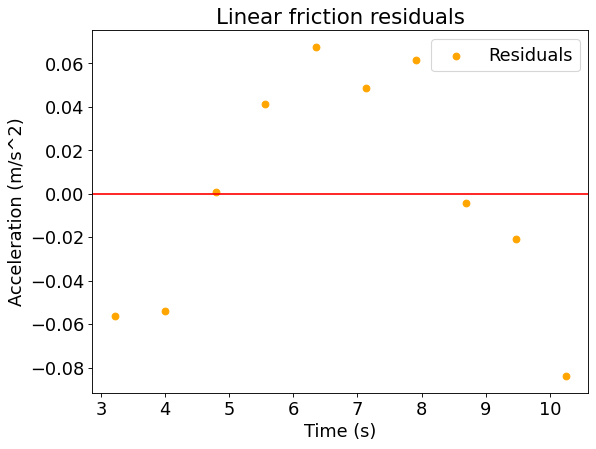

In [75]:
# Residuals
# Sets figure size etc.
fig1=plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': '16'})

# Data and fit
plt.scatter(t_max, ypred - y_max, color='orange', label="Residuals")
plt.axhline(y=0, color='r', linestyle='-')


# Axes label and title
plt.legend()
plt.title("Linear friction residuals")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s^2)")
plt.show()